# Importation des librairies et df

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import missingno as mi
from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
InteractiveShell.ast_node_interactivity = "all"
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path =r'/content/drive/MyDrive/P7_scoring/'
df = pd.read_csv(path + 'df_processed_V2.csv')

In [ ]:
column_list = list(df.select_dtypes(exclude=object).columns)

In [ ]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]


In [ ]:
#train_df = train_df.sample(10000)
train_df.drop(columns =['index','Unnamed: 0','CODE_GENDER'],inplace = True)
test_df.drop(columns =['index','Unnamed: 0','CODE_GENDER'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Gestion des Nan


In [ ]:

nan_columns = pd.Series(train_df.columns[np.where(np.isnan(train_df).sum()>0)])
inf_columns = pd.Series(train_df.columns[np.where(np.isinf(train_df).sum()>0)])
serie_inf_nb = pd.Series(np.empty(len(inf_columns)))
serie_inf_ratio = pd.Series(np.empty(len(inf_columns)))
serie_nan_ratio = pd.Series(np.empty(len(nan_columns)))
serie_nan_nb = pd.Series(np.empty(len(nan_columns)))

for i in range(len(nan_columns)):
    serie_nan_nb[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()
    serie_nan_ratio[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()/len(train_df)

nan_df = pd.concat([nan_columns,serie_nan_nb,serie_nan_ratio],axis=1)
nan_df.rename(columns = {0:'nan_columns',1:'nan_nb',2:'nan_ratio'},inplace= True )

for i in range(len(inf_columns)):
    serie_inf_nb[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()
    serie_inf_ratio[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()/len(train_df)

inf_df = pd.concat([inf_columns,serie_inf_nb,serie_inf_ratio],axis=1)
inf_df.rename(columns = {0:'inf_columns',1:'inf_nb',2:'inf_ratio'},inplace = True )

In [ ]:
#c= upper[to_drop].unstack()
#co = c.sort_values(ascending = False,kind="quicksort")
#co_90=co[co>0.90]
#co_90

In [ ]:
train_df.replace([np.inf,-np.inf],np.nan,inplace = True)
test_df.replace([np.inf,-np.inf],np.nan,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
most_nan =nan_df[nan_df['nan_ratio'] >0.5]

In [ ]:
most_nan

,nan_columns,nan_nb,nan_ratio
3,OWN_CAR_AGE,202927.0,0.659910
5,EXT_SOURCE_1,173376.0,0.563812
8,APARTMENTS_AVG,156060.0,0.507501
9,BASEMENTAREA_AVG,179942.0,0.585164
11,YEARS_BUILD_AVG,204486.0,0.664980
...,...,...,...
571,CC_SK_DPD_DEF_MAX,220602.0,0.717389
572,CC_SK_DPD_DEF_MEAN,220602.0,0.717389
573,CC_SK_DPD_DEF_SUM,220602.0,0.717389
574,CC_SK_DPD_DEF_VAR,221234.0,0.719444


In [ ]:
for column in train_df.columns:
    train_df[column].fillna(train_df[column].mean(),inplace = True)
for column in test_df.columns:
    test_df[column].fillna(test_df[column].mean(),inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
train_df.drop(columns = most_nan['nan_columns'],inplace = True)
test_df.drop(columns = most_nan['nan_columns'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Corrélation entre colonnes 


In [ ]:
# Create correlation matrix
corr_matrix = test_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
#df.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
for column in train_df.columns:
 train_df = train_df[np.abs(train_df[column]-train_df[column].mean()) <= (5*train_df[column].std())]

In [ ]:
train_df_light = train_df.drop(columns=to_drop)
test_df_light = test_df.drop(columns=to_drop)
train_df_light = train_df.copy()
test_df_light = test_df.copy()
for column in test_df_light.columns:
    test_df_light.fillna(test_df_light[column].mean(),inplace = True)   
for column in train_df_light.columns:
    train_df_light[column].fillna(train_df_light[column].mean(),inplace = True)



In [ ]:
np.shape(train_df)

(36830, 560)

In [ ]:
train_id= train_df['SK_ID_CURR'].copy()
test_id= test_df['SK_ID_CURR'].copy()

train_df.drop(columns = 'SK_ID_CURR',inplace =True)
test_df.drop(columns = 'SK_ID_CURR',inplace =True)

X=train_df.drop(columns = 'TARGET')
X_light = train_df_light.drop(columns = 'TARGET')
y = train_df.TARGET

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.TARGET.describe()
test_df_nat = test_df.copy().reset_index(drop = True)

count    36830.000000
mean         0.074776
std          0.263033
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

# Scaling des données

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_light = StandardScaler()
X_ul = X_light.copy()
X_u =X.copy()
scaler.fit(X)
scaler_light.fit(X_light)
X = scaler.transform(X)
X_light = scaler_light.transform(X_light)

StandardScaler()

StandardScaler()

In [ ]:
X_col = train_df.columns
X_col = X_col[1:]

X_light_col = train_df_light.columns
X_light_col = X_light_col[1:]

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,sampling_strategy='minority')
#del train_df
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_l, y_resampled_l = smote.fit_resample(X_light, y)

In [ ]:
np.shape(X_resampled)

(68152, 558)

In [ ]:
#del X
#del y

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,train_size=0.8)
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(X_resampled_l,y_resampled_l,train_size=0.8)

In [ ]:
X_train = pd.DataFrame(X_train,columns = train_df.columns[1:])
X_test = pd.DataFrame(X_test,columns = train_df.columns[1:])
X_train_l = pd.DataFrame(X_train_l,columns = train_df_light.columns[1:])
x_test_l = pd.DataFrame(X_test_l,columns = train_df_light.columns[1:])

# Principal Component Analysis


In [ ]:
#y.value_counts()

0.0    34076
1.0     2754
Name: TARGET, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


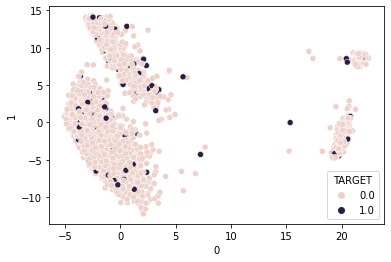

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2).fit(X_light)
# X_pca = pca.transform(X_light)
# pca_result = pd.concat([pd.DataFrame(X_pca),y],axis=1)
# sns.scatterplot(pca_result[0],pca_result[1],hue=pca_result.TARGET)

In [ ]:
#np.argsort(np.abs(pca.components_[0]))[::-1]

In [ ]:
#np.argmax(X_light[479,:])

In [ ]:
#pca.explained_variance_

# modèles de prédiction


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
lr = LogisticRegression()
gb = GaussianNB()
svc = LinearSVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
Knn = KNeighborsClassifier()

In [ ]:
cross_val_score(lr,X_train,y_train,cv=5,scoring='precision').mean()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.728166693198353

In [ ]:
cross_val_score(gb,X_train,y_train,cv=5,scoring='precision').mean()


0.6264902872609349

In [ ]:
cross_val_score(svc,X_train,y_train,cv=5,scoring='precision').mean()


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.706763705296577

In [ ]:
cross_val_score(Knn,X_train,y_train,cv=5,scoring='precision').mean()

0.5867480046342315

In [ ]:
cross_val_score(dtc,X_train,y_train,cv=5,scoring='precision').mean()


0.8830611053424782

In [ ]:
cross_val_score(rfc,X_train,y_train,cv=5,scoring='precision').mean()


0.9943463517233304

# Optimisation Random Forest


In [ ]:
# y_pred = rfc.fit(X_train,y_train).predict(X_test)
# pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1
0,6713,17
1,407,6494


In [ ]:
y_pred = pd.Series(y_pred).reset_index(drop=True)
y_test.reset_index(drop=True,inplace=True)



In [ ]:
from sklearn.metrics import fbeta_score

In [ ]:
def my_custom_loss_func(y_true,y_pred):
  custom_score = 0
  error_count =0
  accuracy =0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
      custom_score =custom_score
      accuracy = accuracy +1
    elif y_true[i]<y_pred[i]: # groundtruth =0, pred =1
      custom_score = custom_score +1
      error_count =error_count+1
    elif y_true[i]> y_pred[i]:
      custom_score =custom_score +5
      error_count =error_count+1
  custom_score =custom_score/error_count
  accuracy =accuracy/len(y_test)
  fbeta = fbeta_score(y_true,y_pred,beta=0.5)  
  return custom_score,fbeta



In [ ]:
# y_pred = dtc.fit(X_train,y_train).predict(X_test)
# pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1
0,5941,789
1,539,6362


In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 308 kB 19.0 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 210 kB 43.6 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 150 kB 48.6 MB/s 
     |████████████████████████████████| 113 kB 38.8 MB/s 
     |████████████████████████████████| 49 kB 3.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e7554e6ac3d6da2f420be37cf7cca4a8fdcffcf356931fa7b3f34c12c8475269
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:

# def objective(trial):    
#     #criterion = trial.suggest_categorical('criterion',['gini'])
#     rf_max_depth = trial.suggest_float('max_depth',2,100,step =5)
#     rf_n_estimator = trial.suggest_int('n_estimators',10,100,step =10)
#     rf_min_samples_split = trial.suggest_int('min_samples_split',2,41,step =2)
#     rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',1,21,step =1)
#     #l1_ratio = trial.suggest_float('l1_ratio',0,1,step =0.1)
#     classifier_obj = RandomForestClassifier(n_estimators = rf_n_estimator,max_depth=rf_max_depth,min_samples_split=rf_min_samples_split,min_samples_leaf=rf_min_samples_leaf)
#     classifier_obj.fit(X_train,y_train)
#     y_pred = pd.Series(classifier_obj.predict(X_test))
#     y_pred.reset_index(drop=True,inplace=True)
#     custom_score,fbeta = my_custom_loss_func(y_test,y_pred)
#     return custom_score,fbeta

# study = optuna.create_study(directions=['minimize','maximize'])
# study.optimize(objective, n_trials=100)

# #trial = study.best_trial
# optuna.visualization.plot_pareto_front(study, target_names=["custom_score", "fbeta"])
# #print('Accuracy: {}'.format(trial.value))
# #print("Best hyperparameters: {}".format(trial.params))

[I 2022-04-12 17:30:38,901] A new study created in memory with name: no-name-49eeeb69-bf8f-4395-b06a-eb8736ae6c88
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [2, 100] and q=5, but the range is not divisible by `q`. It will be replaced by [2, 97.0].
  low=low, old_high=old_high, high=high, step=q
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning: The distribution is specified by [2, 41] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 40].
  low=low, old_high=old_high, high=high, step=step
[I 2022-04-12 17:31:30,914] Trial 0 finished with values: [3.6960110041265475, 0.9570656555101067] and parameters: {'max_depth': 12.0, 'n_estimators': 90, 'min_samples_split': 16, 'min_samples_leaf': 12}. 
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [2, 100] and q=5, but the range is not divisible by `q

KeyboardInterrupt: ignored

In [ ]:

rfc_f = RandomForestClassifier(max_depth =32, n_estimators = 60, min_samples_split =14,min_samples_leaf =1)
y_pred = rfc_f.fit(X_train,y_train).predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test,y_pred))
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True,fmt ='g',cmap ='Blues')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
cross_val_score(rfc_f,X_train,y_train,cv=5)

In [ ]:
cross_val_score(rfc_f,X_train,y_train,cv=5,scoring='precision').mean()

In [ ]:
roc_val = roc_auc_score(y_test,y_pred)

In [ ]:
roc_val

In [ ]:
X_df = pd.DataFrame(X_train,columns = X_col)
X_df_test = pd.DataFrame(X_test,columns = X_col)

In [ ]:
test_df.drop(columns='TARGET',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
test_df=pd.DataFrame(scaler.transform(test_df),columns=X_col)

In [ ]:
# y_prob = rfc.predict_proba(X_test)
# y_test_serie = pd.Series(y_test).drop(columns='index')
# y_test_serie.reset_index(drop=True,inplace =True)
# y_prob = pd.DataFrame(y_prob).reset_index(drop = True)
# y_pred = rfc.predict(X_test)
# y_pred= pd.Series(y_pred)
# df_prob = pd.concat([y_prob,y_test_serie,y_pred],axis =1,ignore_index=True)
# df_prob.columns = ['prob_0','prob_1','y_test','y_pred']
# df_prob.reset_index(inplace = True)

In [ ]:
# from sklearn.metrics import roc_auc_score
# y_prob=pd.DataFrame(y_prob).reset_index(drop=True)
# y_pred = pd.Series(y_pred).reset_index(drop = True)
# df_prob = pd.concat([y_prob,y_test_serie,y_pred],axis =1,ignore_index=True)
# df_prob.columns = ['prob_0','prob_1','y_test','y_pred']
# thresh = [0.1,0.2,0.3,0.4,0.5]
# roc_val_list = []
# y_thresh = np.zeros([len(y_test),1])

# for value in thresh:
#   for i in range(len(y_test)):
#       if df_prob.prob_1[i] > value:# and df_prob.y_test[i] <1:
#         y_thresh[i] =1
#       else :
#         y_thresh[i] = 0
#   roc_val = roc_auc_score(y_test,y_thresh)
#   roc_val_list.append(roc_val)
#   plt.title("AUC score en fonction du seuil")
# sns.lineplot(thresh,roc_val_list)

  #pd.DataFrame(confusion_matrix(y_test,y_thresh))

# Feature importance


In [ ]:
def feat_importance(features,cols):
  feat_indexes =np.flatnonzero(features)
  feat_values = features[feat_indexes]
  feat_names = cols[feat_indexes]

  feat_indexes = pd.Series(feat_indexes,name ='feat_indexes')#.reset_index(drop=True)
  feat_values = pd.Series(feat_values,name ='feat_values')#.reset_index(drop=True)
  feat_names = pd.Series(feat_names,name = 'feat_names')#.reset_index(drop=True)

  features_df = pd.concat([feat_names,feat_indexes,feat_values],axis =1)
  features_df.sort_values(by=['feat_values'],ascending =False,inplace =True)
  plt.figure(figsize=(7,7))
  if len(features_df)>10:
    features_df_plot = features_df.iloc[0:10,:].copy()
  else:
    features_df_plot = features_df.copy()

  sns.barplot(data = features_df_plot,x = 'feat_values',y='feat_names')
  return(features_df.feat_names)

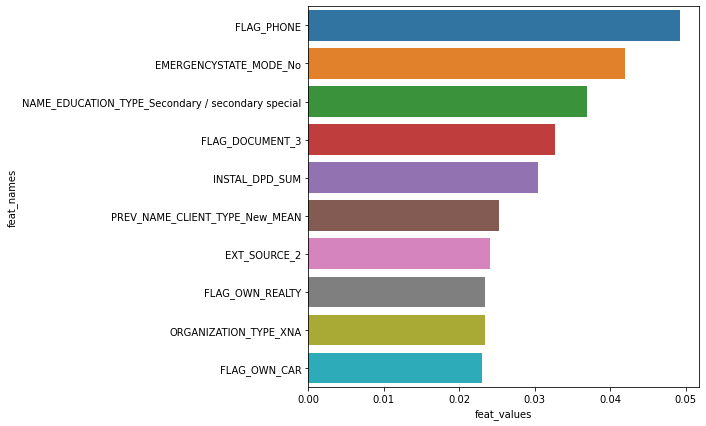

In [ ]:
ft_name_rfc = feat_importance(dtc.feature_importances_,X_df.columns)

In [ ]:
# y_pred_rfc = rfc.predict(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc)
# pd.DataFrame(confusion_matrix(y_test,y_pred_rfc))
# display(metrics.auc(fpr, tpr))

,0,1
0,6713,17
1,407,6494


0.969248518583671

# dimension reduction from feature importances

In [ ]:
ft_keep = list(ft_name_rfc[0:10])
df_red = X_df[list(ft_keep)]
rfc_red = RandomForestClassifier()
rfc_red.fit(df_red,y_train)

RandomForestClassifier()

In [ ]:
# y_pred_rfc_red = rfc.predict(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc_red)
# pd.DataFrame(confusion_matrix(y_test,y_pred_rfc_red))
# display(metrics.auc(fpr, tpr))

,0,1
0,6713,17
1,407,6494


0.969248518583671

In [ ]:
y_pred_test_df = pd.Series(rfc.predict(test_df),name ='prediction').reset_index(drop=True)
y_pred_test_prob = pd.DataFrame(rfc.predict_proba(test_df),columns =['prob_0','prob_1']).reset_index(drop =True)
df_feat = test_df[list(ft_keep)].reset_index(drop=True)
test_id.reset_index(drop=True,inplace =True)
df_results = pd.concat([test_id,df_feat,y_pred_test_df,y_pred_test_prob],axis =1)
df_results_nat = pd.concat([test_id,test_df_nat,y_pred_test_df,y_pred_test_prob],axis =1)

In [ ]:
#df_results_nat.to_csv(path_or_buf=path + 'rfc_results_nat.csv')

In [ ]:
dtc = RandomForestClassifier(max_depth =8, n_estimators = 40, min_samples_split =22,min_samples_leaf =8)
dtc.fit(X_train,y_train)
dtc_pred =dtc.predict(test_df)
y_pred_rfc = dtc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rfc)
pd.DataFrame(confusion_matrix(y_test,y_pred_rfc))
display(metrics.auc(fpr, tpr))

RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=22,
                       n_estimators=40)

,0,1
0,6184,546
1,653,6248


0.9121233802711366

In [ ]:
df_plot =df_results_nat[df_results_nat.prediction ==0].reset_index(drop=True)


In [ ]:
#travail 16/03

#front de pareto sur optimisation du accuracy/coût métier (combien ca coute)
# tracer ROC avec threshold variant
# essayer d'intergrer la fonction cout-metier dans optuna

In [ ]:
#travail 23/03:

#finition streamlit
# lime et shap pour feature importance
# tester plusieurs scénario de ponderation fonction cout metier voir evolution score et feat importances.
# diapo 
#lien model/streamlit

# Explicabilité Locale (test Lime)

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 25.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=6a840010c2bb2a6d48739af298bd22201cbf7db1942ffb8504c55c49a932e2a2
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

In [ ]:

lime_train = np.array(X_train)
explainer = lime.lime_tabular.LimeTabularExplainer(lime_train, mode='classification', feature_names=X_train.columns)



In [ ]:
idx = 125
lime_test = np.array(X_test)
exp = explainer.explain_instance(lime_test[idx], dtc.predict_proba, num_features=10, top_labels=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
exp.show_in_notebook(show_all=False, predict_proba=True, show_predicted_value=True);

In [ ]:
exp.available_labels()

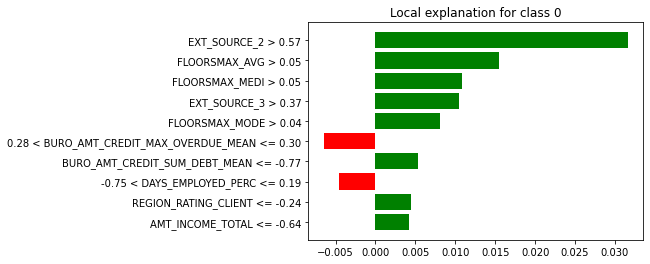

In [ ]:
exp.as_pyplot_figure(label=0);

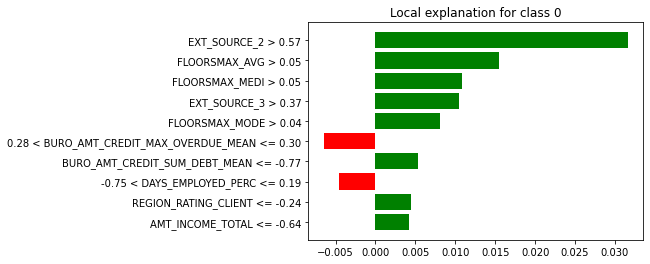

In [ ]:
exp.as_pyplot_figure(label=0)

In [ ]:
exp.as_list(label=0)

[('EXT_SOURCE_2 > 0.57', 0.03163146730005437),
 ('FLOORSMAX_AVG > 0.05', 0.015434311659596672),
 ('FLOORSMAX_MEDI > 0.05', 0.010872372002054063),
 ('EXT_SOURCE_3 > 0.37', 0.010475476478510817),
 ('FLOORSMAX_MODE > 0.04', 0.00803924912295237),
 ('0.28 < BURO_AMT_CREDIT_MAX_OVERDUE_MEAN <= 0.30', -0.006503319149406417),
 ('BURO_AMT_CREDIT_SUM_DEBT_MEAN <= -0.77', 0.005328013221535303),
 ('-0.75 < DAYS_EMPLOYED_PERC <= 0.19', -0.004523839501406102),
 ('REGION_RATING_CLIENT <= -0.24', 0.004507041910532308),
 ('AMT_INCOME_TOTAL <= -0.64', 0.004158822412665182)]

In [ ]:
import json
json_exp = json.dumps(exp.as_list(label=0))

In [ ]:
json_exp

'[["EXT_SOURCE_2 > 0.57", 0.03163146730005437], ["FLOORSMAX_AVG > 0.05", 0.015434311659596672], ["FLOORSMAX_MEDI > 0.05", 0.010872372002054063], ["EXT_SOURCE_3 > 0.37", 0.010475476478510817], ["FLOORSMAX_MODE > 0.04", 0.00803924912295237], ["0.28 < BURO_AMT_CREDIT_MAX_OVERDUE_MEAN <= 0.30", -0.006503319149406417], ["BURO_AMT_CREDIT_SUM_DEBT_MEAN <= -0.77", 0.005328013221535303], ["-0.75 < DAYS_EMPLOYED_PERC <= 0.19", -0.004523839501406102], ["REGION_RATING_CLIENT <= -0.24", 0.004507041910532308], ["AMT_INCOME_TOTAL <= -0.64", 0.004158822412665182]]'

In [ ]:
X_train.columns

In [ ]:
# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)
# y_train = pd.DataFrame(y_train)
# X_train.to_csv(path_or_buf=path + 'X_train.csv')
# X_test.to_csv(path_or_buf=path + 'X_test.csv')
# y_train.to_csv(path_or_buf=path + 'y_train.csv')

In [ ]:
idxs =[102]
feat_list =[]
for i in idxs:
  exp = explainer.explain_instance(lime_test[i], dtc.predict_proba, num_features=10, top_labels=1)
  exp_list =exp.as_list()
  feat_list.append(exp_list)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
for i in idxs:
  print(i)

100


In [ ]:
  exp2 = explainer.explain_instance(lime_test[1,:], dtc.predict_proba, num_features=10, top_labels=2)
  exp_list =exp2.as_list(label =1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
np.shape(lime_test[5])

(558,)

In [ ]:
np.shape(lime_test)

(13631, 558)

In [ ]:
np.shape(lime_test[5])

(558,)

In [ ]:
dtc.predict_proba(lime_test[1].reshape(1, -1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[0.23722782, 0.76277218]])

In [ ]:
row = X_df.iloc[10001]

In [ ]:
X_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,-0.122017,-0.611218,1.084186,-0.703227,-0.214723,0.096590,-0.081267,-0.321386,1.943981,1.346379,...,-0.544851,-0.695111,-0.801637,-0.486428,-0.636797,-0.719568,-0.838838,-0.218341,0.494544,-0.664572
1,-0.617046,-0.611218,1.084186,1.522178,-0.027026,0.608319,-0.078171,1.323827,1.734993,1.493748,...,-0.114017,-0.049004,-0.864359,0.037878,-0.114597,-0.043171,0.350125,-0.150224,0.007997,0.021293
2,1.620626,1.636077,0.627201,-0.578859,-0.389433,0.214992,-0.296165,-0.894381,0.699699,0.402614,...,0.762776,1.148912,-0.846263,1.330498,0.605986,1.048809,0.237780,0.235514,-0.099734,0.538032
3,-0.617046,1.636077,-0.483194,3.026408,0.619292,0.933257,0.607521,-0.045196,0.418249,0.649054,...,2.302028,2.628070,-0.813229,-0.173436,1.733603,2.175700,0.530555,-0.658829,-0.761929,0.592848
4,-0.617046,-0.611218,1.084186,-0.766867,2.045919,0.963409,2.426704,4.335334,1.072075,1.025869,...,-0.636798,-0.431026,-0.866317,-0.586168,-0.663834,-0.451964,-1.059898,-0.384391,-0.007427,-0.093018


In [ ]:
X_train[X_train['FLAG_OWN_CAR']>0].index

Int64Index([    2,     5,    10,    13,    14,    15,    16,    19,    20,
               21,
            ...
            54497, 54499, 54500, 54508, 54511, 54512, 54516, 54518, 54519,
            54520],
           dtype='int64', length=16041)

In [ ]:
# travail mercredi 13/04:
#finir fonction explain sur api :
#créer une matrice avec l'explainer as_list() de chaque client par ligne
#récuperer et envoyer la bonne ligne via post request à streamlit (temps d'execution trop long pour être executer dans la méthode
